In [ ]:
import requests_cache
requests_cache.install_cache('archive_cache')

In [1]:
from pymongo import MongoClient
import requests
from pathlib import Path
import pandas as pd
import glob
from PIL import Image
from io import BytesIO
from matplotlib.pyplot import imshow
import numpy as np
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import json
import magic
from IPython.display import JSON

In [2]:
mongo = MongoClient('172.17.0.1', 27017)
db = mongo['bad-vis']
posts = db['posts']
dlexternalresults = db['dlexternalresults']
dlarchiveresults = db['dlarchiveresults']

In [3]:
images_dir = Path('./images')

In [4]:
error_downloads = [p for p in dlexternalresults.find()
                   if not (p['status'] == 'invalid_url' or
                           p['status'] == 'downloaded' or
                           p['status'] == 'exists' or
                           'skip_' in p['status'])]

In [5]:
len(error_downloads)

777

In [6]:
error_downloads[0]

{'_id': ObjectId('5e352e225a2161cfd5843933'),
 'id': '74e6w7',
 'post_id': 'reddit/dataisugly/74e6w7',
 'link': 'http://www.worldmapper.org/images/largepng/623.png',
 'dest': 'images/external_link/reddit/dataisugly/74e6w7',
 'request_status': 404,
 'status': 'not_found'}

In [7]:
r = requests.get(f"https://archive.org/wayback/available?url={error_downloads[0]['link']}")
r_json = r.json()
JSON(r_json)

<IPython.core.display.JSON object>

In [8]:
url = r_json['archived_snapshots']['closest']['url'].replace('/http', 'if_/http')
url

'http://web.archive.org/web/20130829190754if_/http://worldmapper.org/images/largepng/623.png'

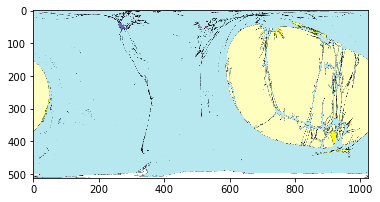

In [9]:
r = requests.get(url)
pil_image = Image.open(BytesIO(r.content))
imshow(np.asarray(pil_image))

In [10]:
def get_content_type_ext (content_type, req=None):
    content_type = content_type.lower()
    if content_type.startswith('image/jpeg') or content_type.startswith('image/jpg'):
        return '.jpg'
    elif content_type.startswith('image/png'):
        return '.png'
    elif content_type.startswith('image/gif'):
        return '.gif'
    elif content_type.startswith('image/webp'):
        return '.webp'
    elif content_type.startswith('image/svg'):
        return '.svg'
    elif content_type.startswith('image/bmp'):
        return '.bmp'
    elif req:
        return get_content_type_ext(magic.from_buffer(req.content, mime=True))
    elif content_type.startswith('text/html'):
        return '.html'
    elif content_type.startswith('application/pdf'):
        return '.pdf'
    else:
        print(f'Unknow content-type: {content_type}')
        return ''

def download_image (post, t='preview', outdir=None):
    if t in post:
        if type(post[t]) == str:
            link = post[t]
        else:
            link = post[t]['url']
    else:
        link = ''
    if not outdir:
        outdir = t
    result = {
        'id': post['id'],
        'post_id': post['post_id'],
        'link': link,
        'dest': images_dir/outdir/post['post_id']
    }

    if len(glob.glob(f'{result["dest"]}*')) != 0:
        result['status'] = 'exists'
        return result
    else:
        result['dest'].parent.mkdir(parents=True, exist_ok=True)

    if not link or link == 'None' or type(link) != str:
        result['status'] = 'invalid_url'
        return result

    try:
        archive_url = f"https://archive.org/wayback/available?url={link}"
        r = requests.get(archive_url)
        r_json = r.json()
        if 'closest' in r_json['archived_snapshots']:
            result['archive_link'] = r_json['archived_snapshots']['closest']['url'].replace('/http', 'if_/http')
            r = requests.get(result['archive_link'])
            result['archive_request_status'] = r.status_code
            if result['archive_request_status'] >= 400:
                result['archive_status'] = 'archive_error'
                return result
        else:
            result['archive_status'] = 'archive_not_found'
            return result

        result['ext'] = get_content_type_ext(r.headers.get('content-type'), r)
        if result['ext'] == '':
            result['status'] = 'invalid_content_type'
            print(f'id: {result["id"]} link: {result["link"]}')
            return result
        if result['ext'] == '.html' or result['ext'] == '.pdf':
            result['status'] = 'skip_content_type'
            return result

        result['output'] = f'{result["dest"]}{result["ext"]}'
        with open(result['output'], 'wb') as f:
            f.write(r.content)
        result['status'] = 'downloaded'
        return result
    except Exception as inst:
        print(f"Download error: {post['post_id']} {link} {inst}")
        print(f"Archive: {post['post_id']} {archive_url}")
        result['status'] = 'download_error'
        return result

    return result

In [17]:
!rm images/archive/reddit/dataisugly/763yfl.png

In [19]:
!ls -al images/archive/reddit/dataisugly/763yfl.png

-rw-r--r-- 1 jovyan jovyan 703496 Feb  2 02:24 images/archive/reddit/dataisugly/763yfl.png


In [18]:
for post in [dlexternalresults.find_one({'id': '763yfl'})]:
    result = download_image(post, t='link', outdir='archive')
    print(result)

{'id': '763yfl', 'post_id': 'reddit/dataisugly/763yfl', 'link': 'https://i.redd.it/86caflkvskrz.png', 'dest': PosixPath('images/archive/reddit/dataisugly/763yfl'), 'archive_link': 'http://web.archive.org/web/20171013104105if_/https://i.redd.it/86caflkvskrz.png', 'archive_request_status': 200, 'ext': '.png', 'output': 'images/archive/reddit/dataisugly/763yfl.png', 'status': 'downloaded'}


In [ ]:
def parallel (f, params_list, params_dict={}, total=None, n_jobs=-2):
    results = []
    with Parallel(n_jobs=n_jobs, require='sharedmem') as p:
        results = p(delayed(f)(params, **params_dict) for params in tqdm(params_list, total=total))
    return results

In [ ]:
dl_archive_results = parallel(download_image, error_downloads, total=len(error_downloads), params_dict={'t': 'link', 'outdir': 'archive'})

In [ ]:
for r in dl_archive_results:
    r['dest'] = str(r['dest'])

dlarchiveresults.drop()
dlarchiveresults.insert_many(dl_archive_results)